In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer,OrdinalEncoder,OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix, ConfusionMatrixDisplay
pd.set_option('display.float_format', '{:.0f}'.format)

In [ ]:
import sklearn
print(sklearn.__version__)

1.6.1


In [ ]:
data=pd.read_csv("/content/cancer.csv",index_col='ID').drop("country",axis=1)
data.head()


,age,gender,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
ID,,,,,,,,,,,,,,,
0,49,Male,2023-10-16,Stage III,Yes,Passive Smoker,18,166,1,1,0,0,Chemotherapy,2025-03-28,0
1,53,Male,2017-04-07,Stage I,No,Former Smoker,41,291,1,0,0,0,Chemotherapy,2018-11-12,0
2,38,Female,2019-04-29,Stage IV,No,Former Smoker,44,255,1,0,1,0,Surgery,2020-05-21,0
3,40,Male,2016-06-22,Stage I,No,Never Smoked,41,285,1,1,0,0,Surgery,2017-11-24,0
4,69,Male,2018-05-31,Stage III,Yes,Current Smoker,28,187,1,1,0,0,Combined,2019-04-25,1


In [ ]:
data.describe()

,age,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,survived
count,32567,32555,32564,32556,32564,32563,32560,32563
mean,939,294,234,19,16,0,3,3
std,72155,28116,42,1357,1239,0,554,554
min,0,0,0,0,0,0,0,0
25%,48,24,199,1,0,0,0,0
50%,55,31,242,1,0,0,0,0
75%,61,38,269,1,1,0,0,0
max,6900000,3580000,300,100000,100000,1,100000,100000


In [ ]:
data.isna().sum()

,0
age,57
gender,0
diagnosis_date,0
cancer_stage,0
family_history,0
smoking_status,0
bmi,69
cholesterol_level,60
hypertension,68
asthma,60


In [ ]:
data.nunique()

,0
age,88
gender,2
diagnosis_date,3648
cancer_stage,4
family_history,2
smoking_status,4
bmi,302
cholesterol_level,156
hypertension,4
asthma,4


In [ ]:
'''def treatmentdays(df):
  start=pd.to_datetime(df.iloc[:,0])
  end=pd.to_datetime(df.iloc[:,1])
  totalduration=(end-start).dt.days
  data.drop(['end_treatment_date','diagnosis_date'],axis=1,inplace=True)
  data['totalduration']=totalduration
  return totalduration.values.reshape(-1,1)
duration_transformation=FunctionTransformer(treatmentdays)'''

"def treatmentdays(df):\n  start=pd.to_datetime(df.iloc[:,0])\n  end=pd.to_datetime(df.iloc[:,1])\n  totalduration=(end-start).dt.days\n  data.drop(['end_treatment_date','diagnosis_date'],axis=1,inplace=True)\n  data['totalduration']=totalduration\n  return totalduration.values.reshape(-1,1)\nduration_transformation=FunctionTransformer(treatmentdays)"

In [ ]:
startdate=pd.to_datetime(data['diagnosis_date'])
enddate=pd.to_datetime(data['end_treatment_date'])
data['totalduration']=(enddate-startdate).dt.days
data.drop(['end_treatment_date','diagnosis_date'],axis=1,inplace=True)


In [ ]:
data=data.copy()
data['survived']=pd.to_numeric(data['survived'],errors='coerce')
data=data.dropna(subset=['survived'])
data['survived']=data['survived'].astype(int)

In [ ]:
limits_continous={'age':(0,100),
        'bmi':(10,60),
        'cholesterol_level':(50,300)
        }
limits_binary=['hypertension','asthma','other_cancer','survived']
mapping_columns=['family_history','gender']

for col,(miv_val,max_val) in limits_continous.items():
  data.loc[(data[col]<miv_val)|(data[col]>max_val),col]=np.nan
for col in limits_binary:
  data.loc[(data[col]>1),col]=np.nan

data=data.dropna(subset=['survived'])

In [ ]:
data.duplicated().sum()
data.drop_duplicates(inplace=True)

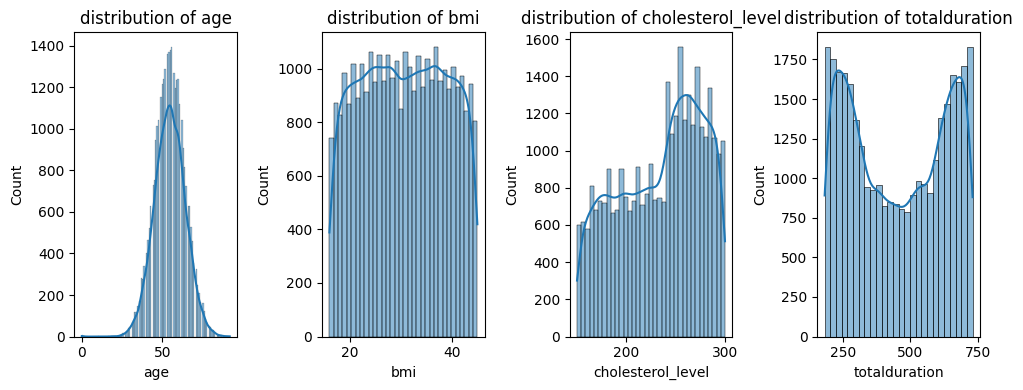

In [ ]:
numerical_cols=['age','bmi','cholesterol_level','totalduration']
plt.figure(figsize=(10,4))
for index,col in enumerate(numerical_cols):
  plt.subplot(1,4,index+1)
  sns.histplot(data[col],kde=True)
  plt.title(f"distribution of {col}")
plt.tight_layout()
plt.savefig("distribution_of_age,bmi,cholesterol,totalduration.png")

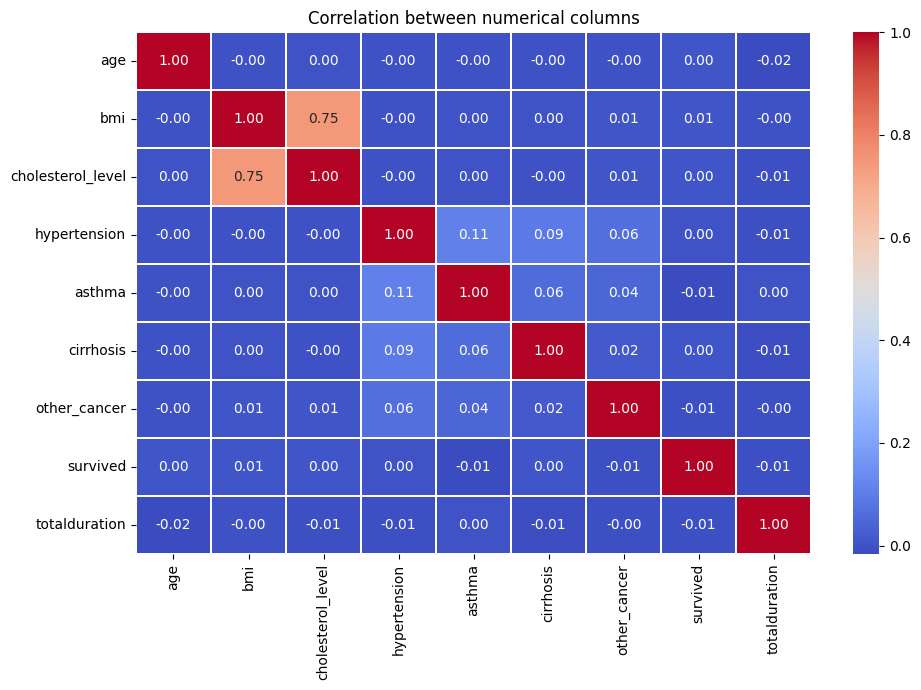

In [ ]:
plt.figure(figsize=(10,7))
numerical_columns=data.select_dtypes(include='number')
correlation_graph=numerical_columns.corr()
sns.heatmap(correlation_graph,annot=True,fmt='.2f',cmap='coolwarm',linewidth=.2)
plt.title("Correlation between numerical columns")
plt.tight_layout()
plt.savefig("correlation.png")

In [ ]:
data['survived'].value_counts()
#irregularity in data


,count
survived,
0,25985
1,6534


In [ ]:
data.head()

,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,survived,totalduration
ID,,,,,,,,,,,,,,
0,49,Male,Stage III,Yes,Passive Smoker,18,166,1,1,0,0,Chemotherapy,0,529
1,53,Male,Stage I,No,Former Smoker,41,291,1,0,0,0,Chemotherapy,0,584
2,38,Female,Stage IV,No,Former Smoker,44,255,1,0,1,0,Surgery,0,388
3,40,Male,Stage I,No,Never Smoked,41,285,1,1,0,0,Surgery,0,520
4,69,Male,Stage III,Yes,Current Smoker,28,187,1,1,0,0,Combined,1,329


In [ ]:
ordinal_bin=[['No','Yes']]
number_binary=['family_history']
num_bin_columns=['hypertension','asthma','cirrhosis','other_cancer']
numerical_continuos_columns=['age','totalduration']
numerical_skewed_columns=['bmi','cholesterol_level']
ordinal_columns=['cancer_stage','smoking_status']
ordinal_values=[['Stage I','Stage II','Stage III','Stage IV'],
 ['Never Smoked','Passive Smoker','Former Smoker','Current Smoker']]


In [ ]:
numerical_continous_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaling',StandardScaler())
])

numerical_skewed_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaling',StandardScaler())
])

ordinal_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('ordinal',OrdinalEncoder(categories=ordinal_values))
])

onehot_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(drop='first',sparse_output=False,handle_unknown='ignore'))
])

binary_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('ordinal',OrdinalEncoder(categories=ordinal_bin,handle_unknown='use_encoded_value',unknown_value=-1))
])
preprocessing=ColumnTransformer([
    ('binary_bin',binary_pipeline,number_binary),
    ('binary',SimpleImputer(strategy='most_frequent'),num_bin_columns),
    ("numerical_continuos",numerical_continous_pipeline,numerical_continuos_columns),
    ('numerical_skewed',numerical_skewed_pipeline,numerical_skewed_columns),
    ('ordinal',ordinal_pipeline,ordinal_columns),
    ('onehot',onehot_pipeline,['treatment_type','gender'])
],remainder='drop')

In [ ]:
X=data.drop(['survived'],axis=1)
y=data['survived']
results={}
models={
    "Random Forest":RandomForestClassifier(random_state=42,class_weight='balanced'),
}
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.35,random_state=42,stratify=y)

for model_name,model in models.items():
  print(f"training {model_name}")
  full_pipeline=imbpipeline(steps=[
      ('preprocessing',preprocessing),
      ('handling imbalances',SMOTE(random_state=42)),
      ('model training',model)
  ])
  full_pipeline.fit(X_train,y_train)
  y_pred=full_pipeline.predict(X_test)
  y_pred_proba=full_pipeline.predict_proba(X_test)[:,1]
  results[model_name]={
      'roc_auc_score': roc_auc_score(y_test,y_pred_proba)
  }
  print(f"Classification Report\n{classification_report(y_test,y_pred)}")


training Random Forest
Classification Report
              precision    recall  f1-score   support

         0.0       0.80      0.96      0.87      9095
         1.0       0.26      0.06      0.10      2287

    accuracy                           0.78     11382
   macro avg       0.53      0.51      0.48     11382
weighted avg       0.69      0.78      0.72     11382



In [ ]:
print(type(full_pipeline))

<class 'imblearn.pipeline.Pipeline'>


In [ ]:

cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Survive', 'Survived'],
            yticklabels=['Not Survive', 'Survived'])
plt.title(f'Confusion Matrix for RandomForest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("confusion matrix of Rf.png")

In [ ]:
feature_names=full_pipeline.named_steps['preprocessing'].get_feature_names_out()
importances=full_pipeline.named_steps['model training'].feature_importances_
clean_names = [name.split('__')[-1] for name in feature_names]
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(clean_names)[indices])
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.savefig("important_features.png")
plt.show()

# ***Final Conclusion***
---
### **Data & Model Used**


The dataset is imbalanced. I tried using SMOTE to create synthetic data, but it didn't significantly improve the results. I tested Random Forest and XGBoost models. Both had a low Recall, meaning they missed a lot of positive cases, but the Random Forest performed slightly better.
Important Features

Based on the Random Forest model, the features that played the biggest role in prediction are:

  - totalduration
  - bmi
  - cholesterol_level
  - age
---
### **Model Performance (Confusion Matrix)**

The Random Forest model is very good at identifying Class 0 (High True Negatives). However, it struggles to predict Class 1 (Survived).

  - True Positives (TP) are very low (132).

  - False Negatives (FN) are very high (2,155). This means the model is mostly guessing "0" and is failing to catch most of the "1" cases.

---

```Future Corrections can be applied like changing the threshold 0.5 to -> 0.3,handling imbalance other than SMOTE(),try ann or more models,tuning hyperparameters if that helps..```

In [ ]:
import pickle
file_name='model.pkl'
with open(file_name,'wb') as f:
  pickle.dump(full_pipeline,f)

In [ ]:
import joblib
filename='preprocessing.pkl'
with open(filename,'wb') as f:
  pickle.dump(preprocessing,f)

In [ ]:
print(data.)